In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import os, re
import glob

import sklearn
import statsmodels
from sklearn.model_selection import train_test_split 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
from pixellib.semantic import semantic_segmentation
import cv2 
import dlib

import urllib
from tensorflow.keras.layers import BatchNormalization
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

# from matplotlib import rc
# rc('font', family='AppleGothic')
# plt.rcParams['axes.unicode_minus'] = False

# 경고 문구 off
import warnings
warnings.filterwarnings('ignore')

# 1. Project_01_인물

### 1) 사진 불러오기

(500, 750, 3)


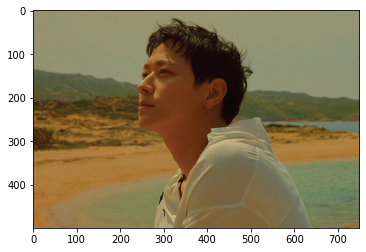

In [2]:
img_path = os.getenv('HOME')+'/aiffel/png/DW.png'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 2) 세그멘테이션으로 Subject 분리하기

In [3]:
# 저장할 파일 이름을 결정

model_dir = os.getenv('HOME')+'/aiffel/png' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file)

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(img_path)

In [4]:
# pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

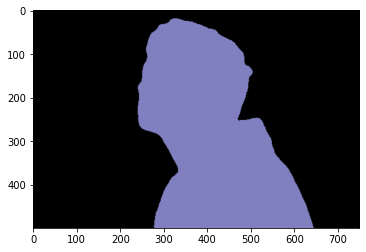

In [5]:
# segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [6]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [7]:
# segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


In [8]:
# 컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]  # 생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [9]:
# colormap[class_id]

colormap[15]  # 사람을 나타내는 색상 : 15

array([192, 128, 128])

In [10]:
seg_color = (128,128,192)  # RGB → BGR

(500, 750)


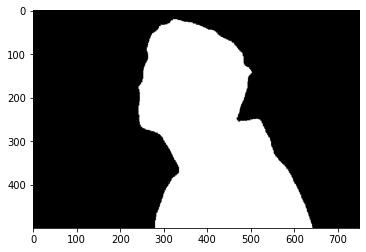

In [11]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

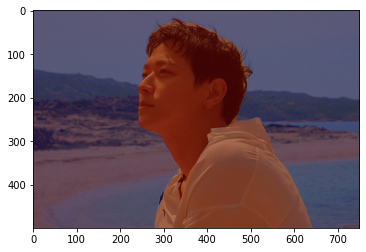

In [12]:
# 원본이미지를 img_show에 할당한 뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든 뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줌
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔줌
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 합치기 (0.6과 0.4는 두 이미지를 섞는 비율)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 3)  배경 흐리게 하기

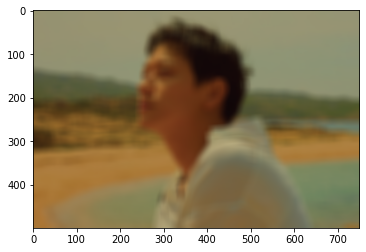

In [13]:
img_orig_blur = cv2.blur(img_orig, (20,20))
  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

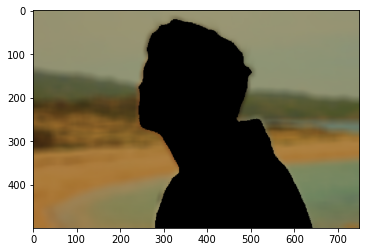

In [14]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

# cv2.bitwise_not(): 이미지가 반전 됨. 배경이 0 사람이 255 였으나 연산을 하고 나면 배경은 255 사람은 0
img_bg_mask = cv2.bitwise_not(img_mask_color)

# cv2.bitwise_and()을 사용하면 배경만 있는 영상을 얻을 수 있음
# 0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됨. 결국 사람이 사라지고 배경만 남음
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 4) 흐린 배경과 원본 영상 합성

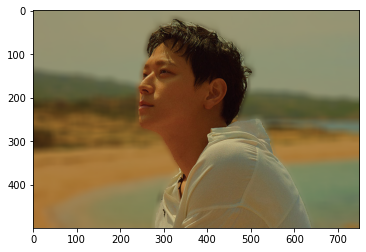

In [15]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### 5) 인물 사진 문제점

인물과 배경의 경계 부분에 띠 모양으로 경계선이 생김

### 6) 해결책 - Gaussian Blur 사용

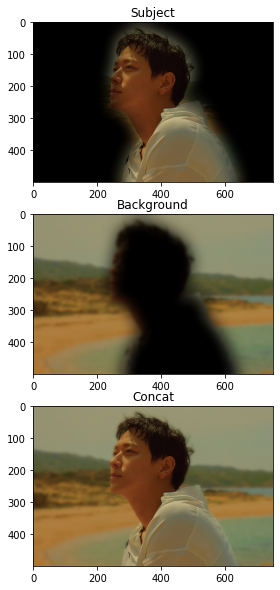

In [16]:
img_mask_new = np.repeat(np.expand_dims(img_mask, axis=2), 3, axis=2).astype(np.uint8)
img_orig_blur = cv2.GaussianBlur(img_orig, (25,25),0)
img_mask_new = (cv2.GaussianBlur(img_mask_new, (101, 101), 25, 25)/255).astype(np.float32)

concat_image_blur = img_mask_new*img_orig.astype(np.float32)
img_bg_mask = (1-img_mask_new)*img_orig_blur.astype(np.float32)
out = (concat_image_blur+img_bg_mask).astype(np.uint8)

fig = plt.figure(figsize=(20, 10))

ax = plt.subplot(311)
plt.imshow(cv2.cvtColor(concat_image_blur.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Subject')

ax = plt.subplot(312)
plt.imshow(cv2.cvtColor(img_bg_mask.astype(np.uint8),cv2.COLOR_BGR2RGB))
ax.set_title('Background')

ax = plt.subplot(313)
plt.imshow(cv2.cvtColor(out,cv2.COLOR_BGR2RGB))
ax.set_title('Concat')

plt.show()

# 2. Project_02_Llama

### 1) 사진 불러오기

(2448, 3264, 3)


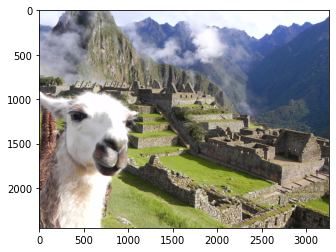

In [17]:
img_path = os.getenv('HOME')+'/aiffel/png/machupicchu_llamas_1.png'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### 2) 세그멘테이션으로 subject 분리하기

In [18]:
model_dir = os.getenv('HOME')+'/aiffel/png' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file) 

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(img_path)

In [19]:
# pascalvoc 데이터의 라벨 종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [20]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
sheep


In [21]:
# 컬러맵 만들기 

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# colormap[:20] #생성한 20개의 컬러맵 출력

In [22]:
# colormap[class_id]

colormap[17]

array([128,  64,   0])

In [23]:
seg_color = (0, 64, 128)

(2448, 3264)


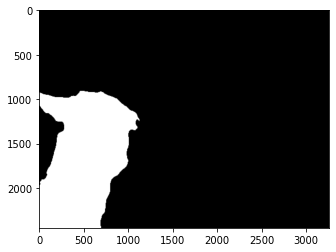

In [24]:
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

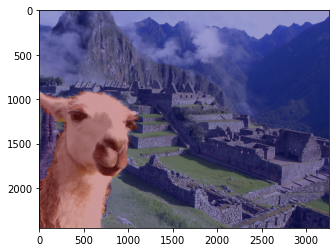

In [25]:
img_show = img_orig.copy()
img_mask = seg_map.astype(np.uint8) * 255
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### 3)  배경 흐리게 하기

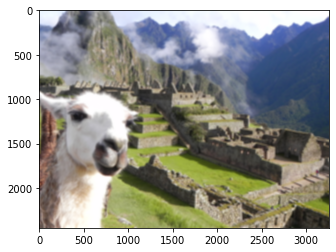

In [26]:
img_orig_blur = cv2.blur(img_orig, (25,25))
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

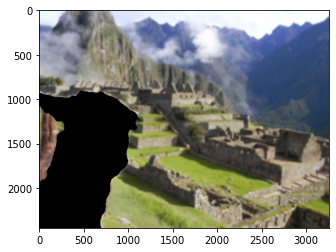

In [27]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### 4) 흐린 배경과 원본 영상 합성

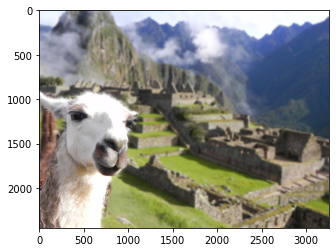

In [28]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 3. Project_03_Chroma_Key

Llama@Salar_de_Uyuni

### 1) 사진 불러오기

(1000, 1500, 3)


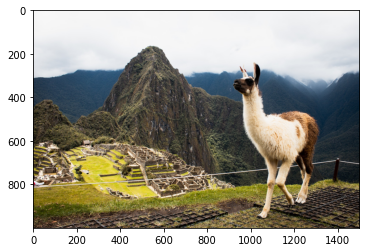

In [29]:
img_path = os.getenv('HOME')+'/aiffel/png/machupicchu_llamas_2.png'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

(1536, 2048, 3)


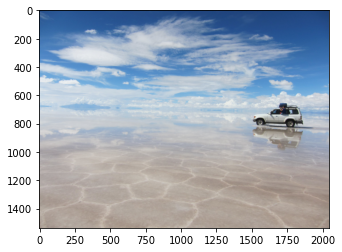

In [30]:
img_path1 = os.getenv('HOME')+'/aiffel/png/uyuni2.png'  
img_orig1 = cv2.imread(img_path1) 
print(img_orig1.shape)

plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

### 2) 이미지 resize 하기

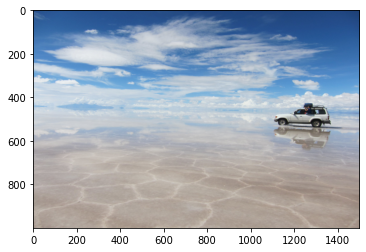

In [31]:
img_orig1 = cv2.resize(img_orig1, dsize=(1500,1000), interpolation=cv2.INTER_AREA)

plt.imshow(cv2.cvtColor(img_orig1, cv2.COLOR_BGR2RGB))
plt.show()

### 3) 세그멘테이션으로 subject 분리하기

In [32]:
model_dir = os.getenv('HOME')+'/aiffel/png' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file) 

model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
segvalues, output = model.segmentAsPascalvoc(img_path)

In [33]:
# pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [34]:
# segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
sheep


In [35]:
# 컬러맵 만들기 

colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# colormap[:20]

In [36]:
# colormap[class_id]

colormap[17]

array([128,  64,   0])

In [37]:
seg_color = (0,64,128)  # RGB -> BGR

seg_map = np.all(output==seg_color, axis=-1)  
img_mask = seg_map.astype(np.uint8) * 255

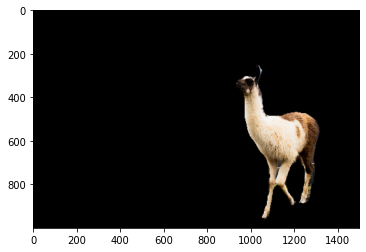

In [38]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_object = cv2.bitwise_and(img_orig, img_mask_color)
plt.imshow(cv2.cvtColor(img_object, cv2.COLOR_BGR2RGB))
plt.show()

### 4) 다른 배경과 원본 영상 합성

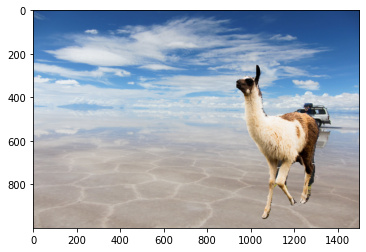

In [39]:
img_concat = np.where(img_mask_color==255, img_object, img_orig1)

plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 4. References

[1] https://deep-learning-study.tistory.com/144

[2] https://lms.aiffel.io/course/382/node/509